In [1]:
# Auto reloads modules when they change
%load_ext autoreload
%autoreload 2

```Flow```
1. EDA
2. Decide model to use
3. Prepare dataset to fit model format and do image augmentations
4. Do a train/test split
5. Use dataloader to split dataset into batches for feeding into model
6. Initialize model
7. Train model
8. Validate model
9. Inference (predict on test.csv)

In [1]:
from src.dataset import wheatDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
)
from torchvision.models import ResNet50_Weights
import torch.optim as optim
import os
from torchvision.ops import nms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [3]:
csv_dir = "./data/global-wheat-detection/train.csv"
image_dir = "./data/global-wheat-detection/train"
image_size = 1024

df = pd.read_csv(csv_dir)
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
# Split image_id 80/20 for for train/val set
train_ids, val_ids = train_test_split(
    df["image_id"].unique().tolist(), test_size=0.2, random_state=42, shuffle=True
)

# Get corresponding image data into dataframe
train_df = df.loc[df["image_id"].isin(train_ids)]
val_df = df.loc[df["image_id"].isin(val_ids)]

# Check if split correctly
print(f"Train images: {len(train_ids)}")
print(f"Val images: {len(val_ids)}")
print(f"Train bbox rows: {len(train_df)}")
print(f"Val bbox rows: {len(val_df)}")

# Check average boxes per image
print(f"Avg boxes per image (train): {len(train_df) / len(train_ids):.2f}")
print(f"Avg boxes per image (val): {len(val_df) / len(val_ids):.2f}")

assert set(train_ids).isdisjoint(set(val_ids)), "Data leakage detected!"

Train images: 2698
Val images: 675
Train bbox rows: 118371
Val bbox rows: 29422
Avg boxes per image (train): 43.87
Avg boxes per image (val): 43.59


In [5]:
# Return tensors and target dict for each dataset
train_dataset = wheatDataset(train_df, image_dir, image_size, mode="train")
val_dataset = wheatDataset(val_df, image_dir, image_size, mode="validation")

train_image, train_target = train_dataset[0]
val_image, val_target = val_dataset[0]

# Check if correct
print(f"Train image shape: {train_image.shape}")
print(f"Train dataset boxes shape: {train_target['boxes'].shape}")

print(f"Val image shape: {val_image.shape}")
print(f"Val dataset boxes shape: {val_target['boxes'].shape}")

Train image shape: torch.Size([3, 1024, 1024])
Train dataset boxes shape: torch.Size([24, 4])
Val image shape: torch.Size([3, 1024, 1024])
Val dataset boxes shape: torch.Size([47, 4])


In [36]:
# Custom collate function since bbox tensors of different shape cannot be stacked
def collate_fn(batch):
    # Separating batch contents from dataloader
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    image_ids = [item[2] for item in batch]

    # Stack images
    images = torch.stack(images)

    # Return tuple with stacked images but non-stacked targets
    return images, targets, image_ids

In [7]:
# Data must be in the format that model wants, images have to be augmented
train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)

val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

for images, targets in train_loader:
    print(images.shape)
    print(len(images))
    print(type(targets))
    print(len(targets))
    print(targets[0].keys())
    print(targets[0]["boxes"].shape)
    break

torch.Size([2, 3, 1024, 1024])
2
<class 'list'>
2
dict_keys(['boxes', 'area', 'labels', 'iscrowd'])
torch.Size([50, 4])


In [8]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.9.0
MPS available: True


In [9]:
# Set device as mps
device = torch.device("cpu")

# Initialize model
model = fasterrcnn_resnet50_fpn(
    weights=None, weights_backbone=ResNet50_Weights.DEFAULT, num_classes=2
)

# Bring model to device
model = model.to(device)

# Set model to train mode
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [11]:
num_epochs = 2
lr = 0.0001
print_freq = 50

optimizer = optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# Combine together
# Make directory to save models
os.makedirs("./checkpoints/models", exist_ok=True)

## Add tqdm next time
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Initialize best val loss
best_val_loss = float("inf")

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} / {num_epochs}")

    # Set model to train mode
    model.train()

    ## Initialize tracking variables
    train_losses = 0.0
    val_losses = 0.0

    for batch_idx, (images, targets, _) in enumerate(train_loader):
        # Load train_data into device
        images = images.to(device)
        targets = [
            {key: value.to(device) for key, value in target.items()}
            for target in targets
        ]

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Convert loss dict to scalar
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass to compute gradients
        losses.backward()

        # Gradient update with optimizer
        optimizer.step()

        # Calculate train tracking metrics
        train_losses += losses.item()

        # Print batch_idx and loss
        if batch_idx % print_freq == 0:
            print(f"Batch index: {batch_idx}/{len(train_loader)}")
            print(f"Batch loss: {losses.item():.4f}")


Epoch 1 / 2
Batch index: 0/1349
Batch loss: 0.6077
Batch index: 50/1349
Batch loss: 0.8614
Batch index: 100/1349
Batch loss: 0.7730
Batch index: 150/1349
Batch loss: 0.7013
Batch index: 200/1349
Batch loss: 0.8937
Batch index: 250/1349
Batch loss: 0.7548
Batch index: 300/1349
Batch loss: 0.6989
Batch index: 350/1349
Batch loss: 0.8302
Batch index: 400/1349
Batch loss: 0.7530
Batch index: 450/1349
Batch loss: 0.9010
Batch index: 500/1349
Batch loss: 0.8208
Batch index: 550/1349
Batch loss: 0.9418
Batch index: 600/1349
Batch loss: 0.9974
Batch index: 650/1349
Batch loss: 0.8474
Batch index: 700/1349
Batch loss: 0.9484
Batch index: 750/1349
Batch loss: 0.9777
Batch index: 800/1349
Batch loss: 0.7820
Batch index: 850/1349
Batch loss: 0.8083
Batch index: 900/1349
Batch loss: 1.0517
Batch index: 950/1349
Batch loss: 0.6425
Batch index: 1000/1349
Batch loss: 0.7527
Batch index: 1050/1349
Batch loss: 0.6684
Batch index: 1100/1349
Batch loss: 0.4980
Batch index: 1150/1349
Batch loss: 0.7159
Bat

AttributeError: 'list' object has no attribute 'values'

In [ ]:

    # Put model to evaluation mode
    model.eval()

    with torch.no_grad():
        for images, targets, image_ids in val_loader:
            images = images.to(device)
            targets = [
                {key: value.to(device) for key, value in target.items()}
                for target in targets
            ]

            # Compute loss
            predictions = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Append loss
            val_losses += losses.item()

    # Calculate tracking metrics
    avg_train_loss = train_losses / len(train_loader)

    # Print metrics
    print(f"Train_loss: {avg_train_loss:.4f}")

    ## Implement with mAP later, just save the last epoch model for now
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": avg_train_loss,
        },
        "./checkpoints/models/best_model.pth",
    )
    print("Saved model)")

In [ ]:
torch.save(
    {
        "epoch": epoch,
        "model_save_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        # "train_loss": avg_train_loss,
        # "val_loss": avg_val_loss,
    },
    "./checkpoints/models/best_model.pth",
)

In [19]:
# Inference (testing first)

# Get one batch from val_loader
images, targets = next(iter(val_loader))

# Set to eval mode
model.eval()

# Inference
with torch.no_grad():
    predictions = model(images)

# Inspect output
print(f"Number of images: {len(predictions)}")
print(f"First prediction keys: {predictions[0].keys()}")
print(f"Boxes shape: {predictions[0]['boxes'].shape}")
print(f"Scores: {predictions[0]['scores']}")
print(f"Labels: {predictions[0]['labels']}")

Number of images: 2
First prediction keys: dict_keys(['boxes', 'labels', 'scores'])
Boxes shape: torch.Size([67, 4])
Scores: tensor([0.9964, 0.9946, 0.9941, 0.9939, 0.9937, 0.9928, 0.9928, 0.9923, 0.9922,
        0.9916, 0.9913, 0.9905, 0.9897, 0.9882, 0.9873, 0.9872, 0.9864, 0.9848,
        0.9842, 0.9827, 0.9823, 0.9813, 0.9785, 0.9760, 0.9710, 0.9709, 0.9704,
        0.9695, 0.9695, 0.9600, 0.9567, 0.9556, 0.9532, 0.9517, 0.9396, 0.9286,
        0.9190, 0.9165, 0.9137, 0.9046, 0.8748, 0.8592, 0.8427, 0.8088, 0.7841,
        0.6584, 0.6293, 0.5675, 0.3872, 0.2911, 0.2455, 0.2153, 0.2144, 0.1410,
        0.1229, 0.1049, 0.1020, 0.0985, 0.0919, 0.0812, 0.0713, 0.0705, 0.0668,
        0.0615, 0.0602, 0.0581, 0.0532])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# Get results that are of certain confidence
threshold = 0.5
mask = predictions[0]["scores"] > threshold

filtered_boxes = predictions[0]["boxes"][mask]
filtered_scores = predictions[0]["scores"][mask]
filtered_labels = predictions[0]["labels"][mask]

print(
    f"After threshold: {len(filtered_boxes)} boxes (was {len(predictions[0]['boxes'])})"
)

# Implement Non-maximum suppresion to remove duplicate/overlapping boxes.
# keeps highest confidence box when multiple boxes detect same object
iou_threshold = 0.5
keep_indices = nms(filtered_boxes, filtered_scores, iou_threshold)

final_boxes = filtered_boxes[keep_indices]
final_scores = filtered_scores[keep_indices]
final_labels = filtered_labels[keep_indices]

print(f"After NMS: {len(final_boxes)} boxes")

After threshold: 48 boxes (was 67)
After NMS: 48 boxes


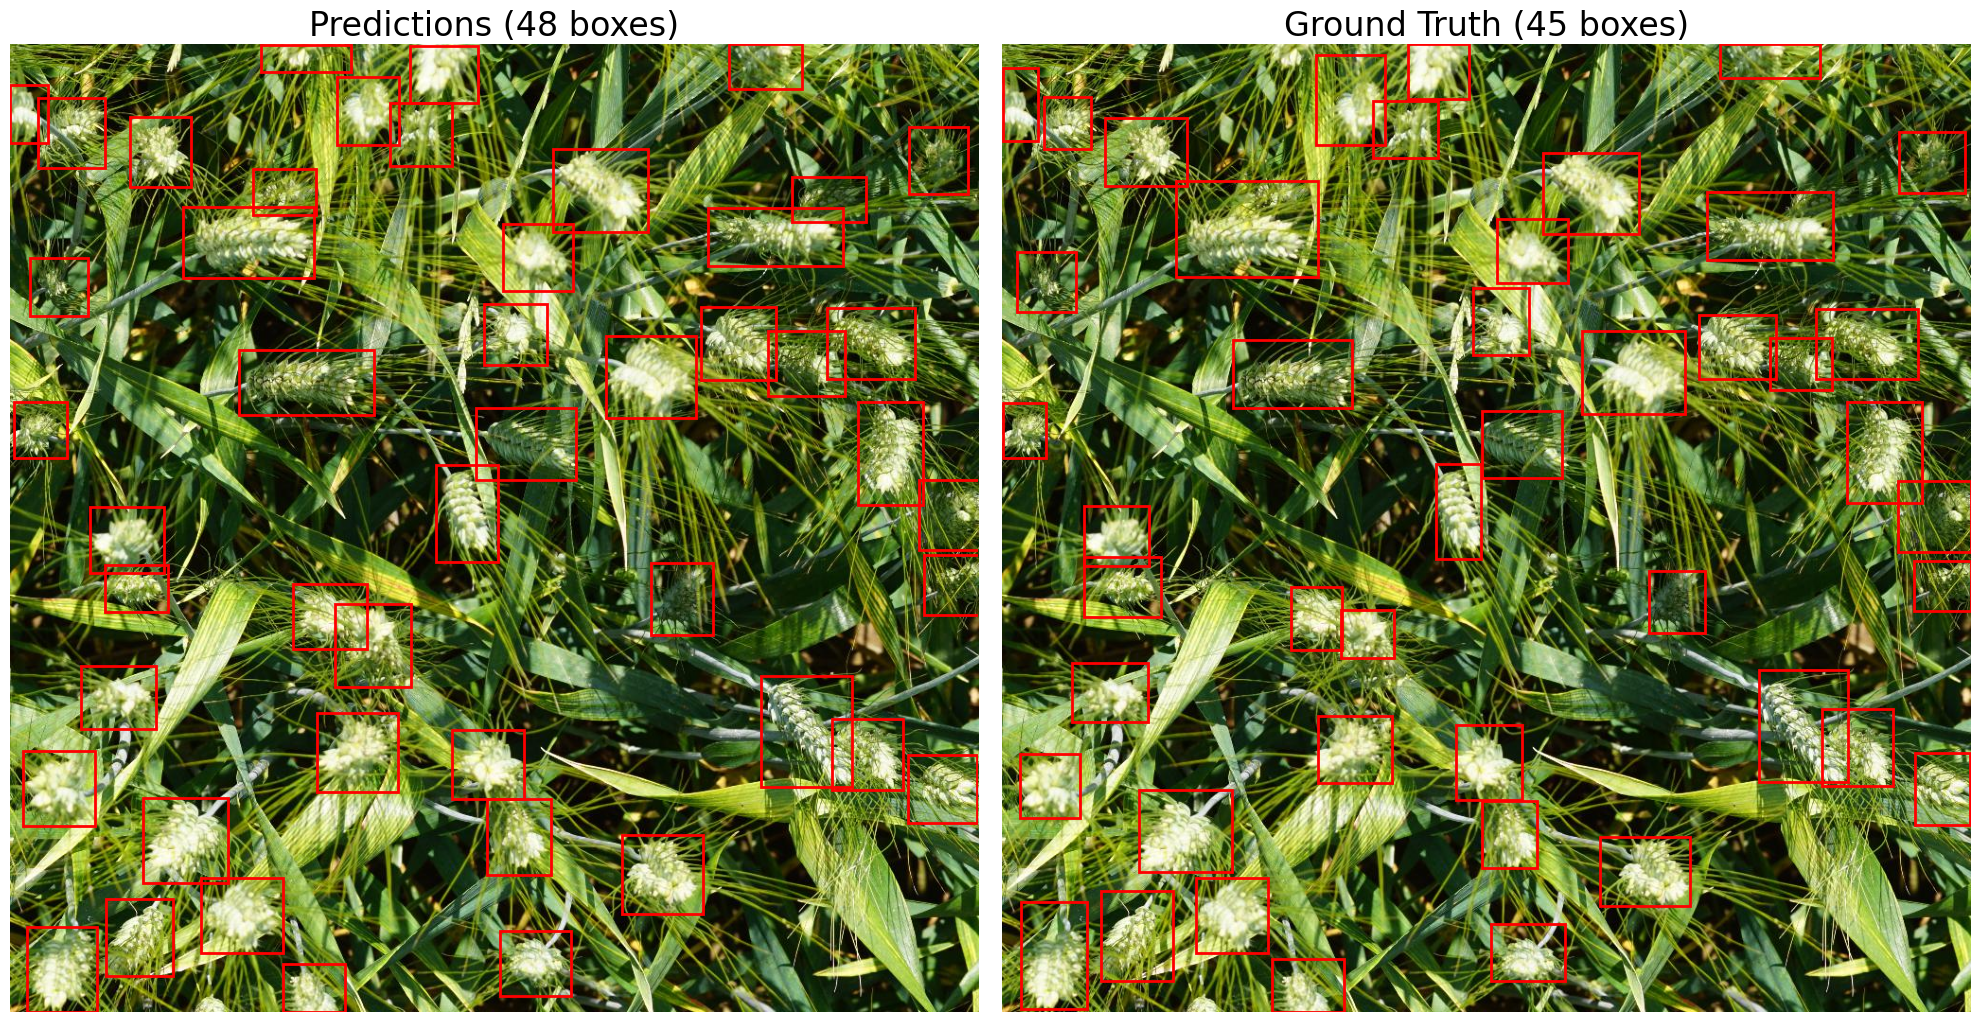

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left: Predictions
img = images[0].cpu().permute(1, 2, 0).numpy()
axes[0].imshow(img)
for box in final_boxes.cpu().numpy():
    xmin, ymin, xmax, ymax = box
    rect = Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor="red",
        facecolor="none",
    )
    axes[0].add_patch(rect)
axes[0].set_title(f"Predictions ({len(final_boxes)} boxes)", fontsize=24)
axes[0].axis("off")

# Right: Ground Truth
axes[1].imshow(img)
for box in targets[0]["boxes"].cpu().numpy():
    xmin, ymin, xmax, ymax = box
    rect = Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=2,
        edgecolor="red",
        facecolor="none",
    )
    axes[1].add_patch(rect)
axes[1].set_title(f"Ground Truth ({len(targets[0]['boxes'])} boxes)", fontsize=24)
axes[1].axis("off")

plt.tight_layout()
plt.show()

```Inference```

In [ ]:
# Instantiate new model
model_inference = fasterrcnn_resnet50_fpn(num_classes=2)

# Load check point
checkpoint = torch.load("./checkpoints/models/best_model.pth")
model_inference.load_state_dict(checkpoint["model_state_dict"])


# Move model to device
model_inference = model_inference.to(device)

# Swtich to eval mode
model_inference.eval()

# Set tracking variable
results = {"boxes": [], "scores": [], "labels": []}

# Inference loop
for batch_idx, (images, targets) in enumerate(val_loader):
    # Put images to device
    images = images.to(device)

    # Get predictions
    with torch.no_grad():
        predictions = model_inference(images)

        # Store predictions into results
        for prediction in predictions:
            results["boxes"].append(prediction["boxes"])
            results["scores"].append(prediction["scores"])
            results["labels"].append(prediction["labels"])


```Next steps```

Path A: Complete Training & Evaluate

1. Let full training finish (2 epochs)
2. Load best checkpoint
3. Run inference on full validation set
4. Calculate mAP metrics (IoU-based evaluation)
5. Understand model performance quantitatively

Path B: Prepare for Kaggle Submission

1. Write inference script for test images
2. Format predictions for Kaggle submission.csv
3. Submit to leaderboard
4. See how you rank

Path C: Organize & Improve Code

1. Move notebook code to .py files (train.py, inference.py, dataset.py)
2. Add proper logging
3. Prepare for training on Kaggle GPU with full dataset
4. Add improvements (augmentations, larger model, more epochs)

Steps:
1. Prepare data with dataset
2. Train test split
3. Dataloader setup
4. Model setup
5. train loop
6. Validation
7. Inference